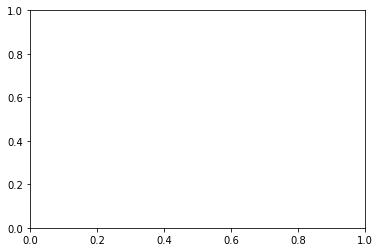

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
#from skimage import exposure

def get_frameset(pfchunk, starttime):
    framelist = []
    start = pfchunk.loc[pfchunk.Time.between(starttime+1.0, starttime+1.5)]
    DIR = np.sign(start.loc[np.argmin(np.abs(start['median_dRotation_cArea'])-1.0), 'median_dRotation_cArea'])
    framelist.append(start.loc[np.argmin(np.abs(start['median_dRotation_cArea'])-1.0), 'FrameNumber'])
    #framelist.append(pfchunk.loc[np.argmin(np.abs(pfchunk['Time']-starttime)), 'FrameNumber'])
    for r in [0.75,0.5,0,-0.5,-0.75, -0.9, -1.0]:
        framelist.append(pfchunk.loc[np.argmin(np.abs(pfchunk['median_dRotation_cArea']-r*DIR)),'FrameNumber'])

    return framelist
    
    
def crop_stitched_img(img):
    if len(img.shape)==2:
        h,w = img.shape
        return img[100:h-100,100:w-100]
    elif len(img.shape)==3:
        h, w, _ = img.shape
        return img[100:h-100,100:w-100,:]

XPOS = 'X#wcentroid'
YPOS = 'Y#wcentroid'
XVEL = 'VX#smooth#wcentroid'
YVEL = 'VY#smooth#wcentroid'
SPEED = 'SPEED#smooth#wcentroid'
ACC = 'ACCELERATION#smooth#wcentroid'
angVel = 'ANGULAR_A#wcentroid'
angAcc = 'ANGULAR_V#wcentroid'

def rotationOrder(centreX, centreY, posX, posY, velX, velY):
    """
    centre - a single point marking the axis of rotation
    pos - position of agents (1 per agent)
    vel - velocity of agents (1 per agent)
    
    Returns: 1d array of rotation order values
    """
    CX = posX - centreX
    CY = posY - centreY
    radius = np.sqrt(CX**2 + CY**2)
    uCX = CX / radius # X component of unit vector R
    uCY = CY / radius # Y component of unit vector R        
    rotation = np.cross(pd.DataFrame({'uCX':uCX,'uCY':uCY}), pd.DataFrame({'velX':velX, 'velY':velY}))

    return rotation

def plot_data_on_video(img, xdata, ydata, colourdata, TEXT, fig=None, ax=None,
                        xlim=(7,312), ylim=(8,327)):
    if fig==None:
        fig = plt.figure(frameon=False)
        fig.set_size_inches(4,4)
    if ax== None:
        ax = fig.add_subplot(111)
    plt.imshow(crop_stitched_img(img), extent=[xlim[0], xlim[1],ylim[0],ylim[1]], origin='lower')
    
    
    props = dict(boxstyle='round', facecolor='#ffffff', alpha=0.75)
    ax.text(0.97, 0.02, TEXT, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

    data = plt.scatter(xdata.values, 
                       ydata.values, 
                       c=np.array(colourdata), s=0.25) 
    
    plt.gca().set_aspect(1.0)
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    
    return fig
    
def create_colourlist(N, cmap='viridis', rev=False):
    import matplotlib.pyplot as plt
    if rev ==True:
        return plt.cm.get_cmap(cmap)(np.linspace(1,0,N))
    else:    
        return plt.cm.get_cmap(cmap)(np.linspace(0,1,N))


def plotnice(plotType='standard', ax=plt.gca()):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if plotType == 'hist':
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    elif plotType=='img':
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.axis('off')
    return



In [46]:

from utilities import *
import stim_handling as stims
import imgstore


In [76]:


def make_panel(MAIN_DIR, TRAIL_TIME,fig, ax,  startCoh='undefined', label='', prestim_frames=12000):

    store = imgstore.new_for_filename(MAIN_DIR + 'metadata.yaml')
    #
    log = stims.get_logfile(MAIN_DIR)

    print('loading pf')
    pf = pd.read_pickle(MAIN_DIR + 'track/perframe_stats.pickle')

    if len(pf.shape) ==1:
        import joblib
        pf = joblib.load(MAIN_DIR + 'track/perframe_stats.pickle')
    if not 'frame' in pf.columns:
        pf['frame'] = pf.index
    if not 'FrameNumber' in pf.columns:
        ret, pf = stims.sync_data(pf, log, store)

    print('loading fbf')
    fbf = pd.read_pickle(MAIN_DIR + 'track/frameByFrameData.pickle')
    if len(fbf.shape) ==1:
        import joblib
        fbf = joblib.load(MAIN_DIR + 'track/frameByFrameData.pickle')
    if not 'frame' in fbf.columns:
        fbf['frame'] = fbf.index
    if not 'FrameNumber' in fbf.columns:
        print('merging framenumber')
        fbf = fbf.merge(pf[['FrameNumber','frame']], left_on='frame', right_on='frame')
        #ret, fbf = stims.sync_data(fbf, log, store)

    fbf.loc[:,'uVX'] = fbf.loc[:,XVEL] / fbf.loc[:,SPEED]
    fbf.loc[:,'uVY'] = fbf.loc[:,YVEL] / fbf.loc[:,SPEED]
    fbf['R'] = rotationOrder(160,160,fbf[XPOS],fbf[YPOS],fbf['uVX'],fbf['uVY'])
    fbf['colVal'] = fbf['R']/2.0 +0.5 #rescale to 0-1

    if startCoh == 'undefined':
        frame = store.frame_min + prestim_frames
    else:
        frame = int(pf.iloc[(pf['median_dRotation_cArea']-startCoh).abs().argsort()[:1]]['FrameNumber'].values)
    
    
    #rpf = pf.loc[pf['Time'].between(T0, T0+45),:]
    #framelist = get_frameset(rpf, T0)
    #rfbf = fbf.loc[fbf['time'].between(T0, T0+45),:]

    try:
        img, (f, t) = store.get_image(frame)
    except:
        img, (f, t) = store.get_next_image()

    #img = exposure.adjust_sigmoid(img, 0.40, 8)

    #ax.imshow(img, cmap='gray', origin=flipped[i])
    #plotnice('img')
    #ax.set_aspect('equal')

    plotdata = fbf.loc[fbf['FrameNumber'].between(frame-TRAIL_TIME, frame), :]
    plotdata = plotdata[['colVal','time',XPOS,YPOS]].dropna()
    #plotdata = drop_bad_tracks(plotdata)
    #plotdata = plotdata.loc[(plotdata['SPEED#smooth#wcentroid'] >= 0.1) & (plotdata['BORDER_DISTANCE#wcentroid'] > 20), :] 
    #COLOURS = np.array([colours[x] for x in plotdata.trackid.values])
    COLOURS = plt.cm.get_cmap('viridis')(plotdata['colVal'])
    COLOURS[:,3] = (plotdata['time'] - plotdata['time'].min()) / (plotdata['time'].max() -plotdata['time'].min())

    fig = plot_data_on_video(img, plotdata[XPOS], plotdata[YPOS], 
                        COLOURS, 
                        label, fig=fig, ax=ax,
                        xlim=(7,312), ylim=(8,327))    



    return fig
    """
    plotnice('img')
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    #plt.show() #FIXME
    plt.savefig(MAIN_DIR + 'track/storyboard_'+str(int(args.time)) + '.png', dpi=200)
    plt.savefig(MAIN_DIR + 'track/storyboard_'+str(int(args.time)) + '.svg', dpi=200)
    plt.close('all')
    """

In [48]:
fig2b =['/media/recnodes/recnode_2mfish/coherencetestangular3m_8_dotbot_20190909_113201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_16_dotbot_20190924_112201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_32_dotbot_20190923_114201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_64_dotbot_20181023_143201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181211_105201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_256_dotbot_20181011_113201.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_512_dotbot_20181017_143202.stitched',
        '/media/recnodes/recnode_2mfish/coherencetestangular3m_1024_dotbot_20190201_113201.stitched']

up128 = ['/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181008_173202.stitched',  #0    
         '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181008_125201.stitched',  #20      
         '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181004_125201.stitched',  #40      
         '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181004_153201.stitched',  #60        
         '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181004_141201.stitched',   #80     
         '/media/recnodes/recnode_2mfish/coherencetestangular3m_128_dotbot_20181008_105201.stitched']   #100 

In [82]:
def doit(filelist, labels, **kwargs):
    N = len(filelist)

    if N <=3:
        gridsize=(1,N)
    elif N <=10:
        gridsize=(2,int(N/2 + N%2))
    elif N <=18:
        gridsize=(3,int(N/3 + N%3))
    #gridsize = (int(N**0.5), N/int(N**0.5) + N%(int(N**0.5)))

    fig = plt.figure(figsize=(gridsize[1]*4, gridsize[0]*4))
    gs1 = gridspec.GridSpec(gridsize[0], gridsize[1])
    gs1.update(wspace=0.025, hspace=0.025)
    
    prestim_frames = kwargs['prestim_frames']
    
    for i in range(N):
        ax = fig.add_subplot(gs1[i])
        _,GS,_,_,_ = slashdir(filelist[i]).split('/')[-2].split('_')
        if int(GS) > 64:
            nFrames = 40
        else:
            nFrames = 120
        fig = make_panel(slashdir(filelist[i]), nFrames,fig, ax, prestim_frames=prestim_frames,  label=labels[i])

In [84]:
for idx in range(20):
    randFrame = np.random.randint(1000,20000)
    print(randFrame)
    doit(fig2b, ['8','16','32','64','128','256','512','1024'], prestim_frames=randFrame)
    plt.savefig('/media/recnodes/Dan_storage/2019_VCRDM_prep/fig2b01_%06d.png'%randFrame)
    plt.close('all')

7844


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
8021


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
2333


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
11371


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
1277


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
13541


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
8518


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
11523


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
11643


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
4804


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
18110


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
18641


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
3666


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
5823


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
2148


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
1996


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
7315


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
15741


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
10217


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
15838


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


In [85]:
for idx in range(20):
    randFrame = np.random.randint(1000,20000)
    print(randFrame)
    doit(up128, ['0.0','0.2','0.4','0.6','0.8','1.0'], prestim_frames=randFrame)
    plt.savefig('/media/recnodes/Dan_storage/2019_VCRDM_prep/fig2c01_%06d.png'%randFrame)
    plt.close('all')

1302


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


9706
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
2747


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
14318


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


16500
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


7586
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
12504


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


15009
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
18462


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
9288


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
14701


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


6264
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
16103


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
2289


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
6396


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


15551
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
4062


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


5740
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber
13689


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


18332
loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


In [54]:
MAIN_DIR = slashdir(fig2b[0])
store = imgstore.new_for_filename(MAIN_DIR + 'metadata.yaml')
frame = store.frame_min + 456
log = stims.get_logfile(MAIN_DIR)

print('loading pf')
pf = pd.read_pickle(MAIN_DIR + 'track/perframe_stats.pickle')

if len(pf.shape) ==1:
    import joblib
    pf = joblib.load(MAIN_DIR + 'track/perframe_stats.pickle')
if not 'frame' in pf.columns:
    pf['frame'] = pf.index
if not 'FrameNumber' in pf.columns:
    ret, pf = stims.sync_data(pf, log, store)

print('loading fbf')
fbf = pd.read_pickle(MAIN_DIR + 'track/frameByFrameData.pickle')
if len(fbf.shape) ==1:
    import joblib
    fbf = joblib.load(MAIN_DIR + 'track/frameByFrameData.pickle')
if not 'frame' in fbf.columns:
    fbf['frame'] = fbf.index
if not 'FrameNumber' in fbf.columns:
    print('merging framenumber')
    fbf = fbf.merge(pf[['FrameNumber','frame']], left_on='frame', right_on='frame')
    #ret, fbf = stims.sync_data(fbf, log, store)

fbf.loc[:,'uVX'] = fbf.loc[:,XVEL] / fbf.loc[:,SPEED]
fbf.loc[:,'uVY'] = fbf.loc[:,YVEL] / fbf.loc[:,SPEED]
fbf['R'] = rotationOrder(160,160,fbf[XPOS],fbf[YPOS],fbf['uVX'],fbf['uVY'])
fbf['colVal'] = fbf['R']/2.0 +0.5 #rescale to 0-1


loading pf
loading fbf
merging framenumber


In [69]:
int(pf.iloc[(pf['median_dRotation_cArea']-0.4).abs().argsort()[:1]]['frame'].values)

9277

/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)


loading pf
loading fbf
merging framenumber


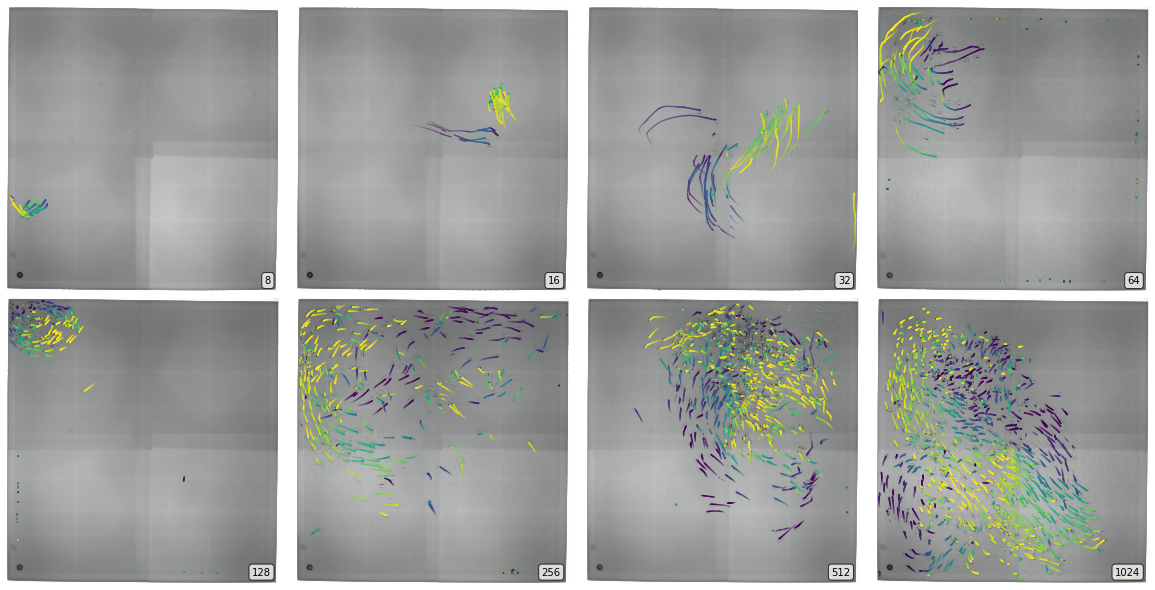

In [74]:
doit(fig2b, ['8','16','32','64','128','256','512','1024'], prestim_frames=0, startCoh=0.4)